# Main

## import packages

In [1]:
import numpy as np
import pandas as pd
import idx2numpy

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import PIL

import time

In [2]:
def calculate_execution_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Execution time of {func.__name__}: {end_time - start_time} seconds")
        return result
    return wrapper

## class for the Activation functions

In [3]:
class Activation:
    def __init__(self, name):
        self.name = name
        if name == 'sigmoid':
            self.function = self.exponent
            self.derivative = self.exponent_der
        elif name == 'tanh':
            self.function = lambda x: np.tanh(x)
            self.derivative = lambda x: 1 - np.square(np.tanh(x))
        elif name == 'softmax':
            self.function = self.softmax
            self.derivative = self.softmax_der
        elif name == 'relu':
            self.function = lambda x: np.maximum(0, x)
            self.derivative = lambda x: x > 0
        
    def exponent(self, x):
        shift_x = x - np.max(x)
        return 1/(1 + np.exp(-shift_x))
    
    def exponent_der(self, x):
        exps = self.exponent(x)
        return exps * (1 - exps)
    
    def softmax(self, x):
        shift_x = x - np.max(x)
        exps = np.exp(shift_x)
        return exps/np.sum(exps)
    
    def softmax_der(self, x):
        array = self.softmax(x).reshape(-1,1)
        return np.diagflat(array) - np.dot(array, array.T)

## Convolution layer

In [4]:
class Conv:

    def __init__(self, num_filters = 3, size = 3, stride = 1, activation = 'relu'):
        self.next_layer = None
        self.num_filters = num_filters
        self.size = size
        self.stride = stride
        self.activation = Activation(activation)

        self.filters = np.random.randn(num_filters, size, size) / 10
    
    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time            
    def forward(self, image):
        self.last_input = image
        input_dimension = image.shape[1]
        output_dimension = int((input_dimension - self.size) / self.stride) + 1
        out = np.zeros((self.filters.shape[0], output_dimension, output_dimension))
        
        for f in range(self.num_filters):
            current_y = out_y = 0
            
            while current_y + self.size <= input_dimension:
                current_x = out_x = 0
                
                while current_x + self.size <= input_dimension:
                    patch = image[:, current_y:current_y + self.size, current_x:current_x + self.size]
                    out[f, out_y, out_x] = np.sum(self.filters[f] * patch)
                    current_x += self.stride
                    out_x += 1
                    
                current_y += self.stride
                out_y += 1
                
        self.last_output = out
        if self.activation:
            out = self.activation.function(out)
        return out
    # @calculate_execution_time
    def backward(self, out_prev, lr):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        input_dimension = self.last_input.shape[1]
        
        if self.activation:
            out_prev = out_prev * self.activation.derivative(self.last_output)
        
        out_next = np.zeros(self.last_input.shape)
        dfilt = np.zeros(self.filters.shape)
        
        for f in range(self.filters.shape[0]):
            current_y = out_y = 0
            
            while current_y + self.size <= input_dimension:
                current_x = out_x = 0
                
                while current_x + self.size <= input_dimension:
                    patch = self.last_input[:, current_y:current_y + self.size, current_x:current_x + self.size]
                    dfilt[f] += np.sum(out_prev[f, out_y, out_x] * patch, axis=0)
                    out_next[:, current_y:current_y + self.size, current_x:current_x + self.size] += out_prev[f, out_y, out_x] * self.filters[f]
                    current_x += self.stride
                    out_x += 1
                    
                current_y += self.stride
                out_y += 1
                
        self.filters -= lr * dfilt
        return out_next

## Pool method

In [5]:
class MaxPool:
    
    def __init__(self, size = 2, stride = 2, activation = 'relu'):
        self.next_layer = None
        self.stride = stride
        self.size = size
        self.activation = Activation(activation)
    
    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time            
    def forward(self, image):
        self.last_input = image
        
        nfilt, h_prev, w_prev = image.shape
        h = int((h_prev - self.size) / self.stride) + 1
        w = int((w_prev - self.size) / self.stride) + 1
        
        downscaled = np.zeros((nfilt, h, w))
        
        for i in range(nfilt):
            curr_y = out_y = 0
            
            while curr_y + self.size <= h_prev:
                curr_x = out_x = 0
                
                while curr_x + self.size <= w_prev:
                    patch = image[i, curr_y:curr_y + self.size, curr_x:curr_x + self.size]
                    downscaled[i, out_y, out_x] = np.max(patch)
                    curr_x += self.stride
                    out_x += 1
                    
                curr_y += self.stride
                out_y += 1
                
        return downscaled
    # @calculate_execution_time
    def backward(self, out_prev, learning_rate):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        out_next = np.zeros(self.last_input.shape)

        nfilt, shape, _ = self.last_input.shape
        
        for c in range(nfilt):
            current_y = out_y = 0
            while current_y + self.size <= shape:
                current_x = out_x = 0
                while current_x + self.size <= shape:
                    patch = self.last_input[c, current_y:current_y + self.size, current_x:current_x + self.size]
                    (x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)
                    out_next[c, current_y + x, current_x + y] += out_prev[c, out_y, out_x]
                    current_x += self.stride
                    out_x += 1
                current_y += self.stride
                out_y += 1
        return out_next

## Dense Layer

In [6]:
class Dense():
    def __init__(self, n_inputs, n_neurons, activation):
        self.next_layer = None
        # self.weights = np.random.uniform(size=(n_inputs, n_neurons)) - 0.5
        # self.biases = np.random.uniform(size=(n_neurons,)) - 0.5
        
        # self.weights = np.random.normal(loc=0, scale=np.sqrt(2/n_inputs), size=(n_inputs, n_neurons))
        # self.biases = np.random.normal(loc=0, scale=np.sqrt(2/n_inputs), size=(n_neurons))
        
        self.weights = np.random.randn(n_inputs, n_neurons) / 10
        self.biases = np.random.randn(n_neurons) / 10
        
        self.activation = Activation(activation)

    def add_layer(self, child):
        self.next_layer = child
        return self
    
    # @calculate_execution_time
    def forward(self, image):
        self.last_input_shape = image.shape
        image = image.flatten()
        output = np.dot(image, self.weights) + self.biases
        self.last_input = image
        self.last_output = output
        return self.activation.function(output)
    
    # @calculate_execution_time
    def backward(self, out_prev, learning_rate):
        out_prev = np.clip(out_prev, -1e+5, 1e+5)
        
        if self.next_layer is None:
            dW = out_prev[:, np.newaxis]
        else:
            dW = out_prev[:, np.newaxis] * self.activation.derivative(self.last_output)[:, np.newaxis]
        dW = (dW * self.last_input[np.newaxis, :]).T
        db = np.copy(out_prev)
        out_next = self.weights @ out_prev
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        return out_next.reshape(self.last_input_shape)

## CNN

In [7]:
class CNN:
    
    def __init__(self, layers):
        if len(layers) < 2:
            raise ValueError("Not enough layers. Should be at least 2")
        
        self.layers = [layers[0]]
        
        for layer in layers[1:]:
            self.layers[-1].add_layer(layer)
            if layer is not None and layer not in self.layers:
                self.layers.append(layer)
        
        self.early_stop = None
        
    # @calculate_execution_time
    def forward(self, image):
        for layer in self.layers:
            image = layer.forward(image)
        return image
    
    # @calculate_execution_time
    def backward(self, gradient, learning_rate):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

    def train(self, X_train, y_train, X_val = None, y_val = None, epochs=10, learning_rate=0.1, lr_decay=0, step=50, val_step=100):
        data_amount = X_train.shape[0]
        num_digits = len(str(data_amount))
        learning_rate_0 = learning_rate
            
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}')
            accuracies = []
            losses = []
            
            self.history['accuracy'][epoch] = []
            self.history['loss'][epoch] = []
                
            self.history['val_accuracy'][epoch] = []
            self.history['val_loss'][epoch] = []
            
            for i, X in enumerate(X_train):              
                output = self.forward(X)
                
                accuracy = output[np.argmax(y_train[i])]
                loss = -np.sum(y_train[i] * np.log(output))
                accuracies.append(accuracy)
                losses.append(loss)
                
                gradient = np.copy(output) - y_train[i]
                self.backward(gradient, learning_rate)
                
                learning_rate = (1/(1+lr_decay*((epoch + 1) * (i + 1)))) * learning_rate_0
                
                if i > val_step and i % step == 0:
                    avg_loss = np.mean(losses)
                    avg_accuracy = np.mean(accuracies)
                    accuracies = []
                    losses = []
                    
                    if self.early_stop is not None:
                        if self.EarlyStopping(epoch, i, accuracy, loss, step, val_step, X_val, y_val):
                            self.output = np.array(output)
                            return
                    
                    val_accuracy, val_loss = self.history['val_accuracy'][epoch][-1], self.history['val_loss'][epoch][-1]
                    
                    print(f'[Image {i:{num_digits}d}]: ' +
                          f'Avg Loss {avg_loss:5.2f} | ' +
                          f'Avg Acc: {avg_accuracy:7.2%} | ' +
                          f'Val Loss: {val_loss:5.2f} | ' +
                          f'Val Acc: {val_accuracy:7.2%}')

    def val_pred(self, X_val, y_val):
        accuracies = []
        losses = []
        
        for i, X in enumerate(X_val):
            current_output = self.forward(X)
            
            accuracy = current_output[np.argmax(y_val[i])]
            loss = -np.sum(y_val[i] * np.log(current_output))
            accuracies.append(accuracy)
            losses.append(loss)
            
        return np.mean(accuracies), np.mean(losses)
        
    def predict(self, X):
        return np.array([np.argmax(self.forward(x), 0) for x in X])
        
    def EarlyStop(self, monitor="accuracy", min_delta=.1, min_monitor = 0.6, patience=3, restore_best_layers=False):
        self.early_stop = {
            "monitor": monitor, 
            "min_delta": min_delta, 
            "min_monitor": min_monitor, 
            "patience": patience,
            "restore_best_layers": restore_best_layers,
        }
        
        self.history = {
            "accuracy": {},
            "loss": {},
            'val_accuracy': {},
            'val_loss': {},
            "global_max_index": (0, 0),
            "best_layers": []
        }
    
    def EarlyStopping(self, epoch, im_i, accuracy, loss, step, val_step, X_val=None, y_val=None):
        
        im_i = int((im_i - val_step)/step) - 1
        
        self.history['accuracy'][epoch].append(accuracy)
        self.history['loss'][epoch].append(loss)
        
        val_accuracy, val_loss = self.val_pred(X_val, y_val)
        self.history['val_accuracy'][epoch].append(val_accuracy)
        self.history['val_loss'][epoch].append(val_loss)
        
        if ((epoch + 1) * (im_i + 1)) > self.early_stop['patience']:
            
            if self.history[self.early_stop['monitor']][epoch][-1] >= self.history[self.early_stop['monitor']][self.history['global_max_index'][0]][self.history['global_max_index'][1]]:
                self.history['global_max_index'] = (epoch, im_i)
            
            if self.early_stop['restore_best_layers'] and (epoch, im_i) == self.history['global_max_index']:
                self.history['best_layers'] = []
                for layer in self.layers:
                    if layer.__class__.__name__ == 'Conv':
                        self.history['best_layers'].append(layer.filters)
                    elif layer.__class__.__name__ == 'MaxPool':
                        self.history['best_layers'].append(None)
                    elif layer.__class__.__name__ == 'Dense':
                        self.history['best_layers'].append((layer.weights, layer.biases))
                
            min_local_accuracy = min(self.history[self.early_stop['monitor']][epoch][-self.early_stop['patience']:])
            difference = abs(min_local_accuracy - self.history[self.early_stop['monitor']][self.history['global_max_index'][0]][self.history['global_max_index'][1]])
            
            if min_local_accuracy >= self.early_stop['min_monitor'] and difference < self.early_stop['min_delta']:
                if self.early_stop['restore_best_layers']:
                    for i, layer in enumerate(self.layers):
                        if layer.__class__.__name__ == 'Conv':
                            layer.filters = self.history['best_layers'][i]
                        elif layer.__class__.__name__ == 'MaxPool':
                            continue
                        elif layer.__class__.__name__ == 'Dense':
                            layer.weights, layer.biases = self.history['best_layers'][i]
                return True
        return False
    
    def restore_best_layers(self):
        if self.early_stop['restore_best_layers']:
            for i, layer in enumerate(self.layers):
                if layer.__class__.__name__ == 'Conv':
                    layer.filters = self.history['best_layers'][i]
                elif layer.__class__.__name__ == 'MaxPool':
                    continue
                elif layer.__class__.__name__ == 'Dense':
                    layer.weights, layer.biases = self.history['best_layers'][i]

## Training

### import data

In [8]:
# # data = pd.read_csv("train.csv").sample(frac=.05).to_numpy()
# X = idx2numpy.convert_from_file('D:\\Programming\\Projects\\data_sets\\num_mnist_X.idx3-ubyte').astype('float32')
# Y = idx2numpy.convert_from_file('D:\\Programming\\Projects\\data_sets\\num_mnist_Y.idx1-ubyte')

# X = X.reshape(-1, 1, 28, 28)

# # minmax
# X = (X - np.min(X, axis=(2,3), keepdims=True)) / (np.max(X, axis=(2,3), keepdims=True) - np.min(X, axis=(2,3), keepdims=True))

# # Z-score
# # X = (X - np.mean(X, axis=(2,3), keepdims=True)) / np.var(X, axis=(2,3), keepdims=True)

# Y_onehot = OneHotEncoder().fit_transform(Y.reshape(-1, 1)).toarray()

# X_train, X_test, y_train, y_test = train_test_split(X, Y_onehot, test_size=0.05, random_state=101)

# percent = 0.1
# sample = np.random.choice([True, False], size=X_test.shape[0], p=[percent, 1-percent])
# X_val = X_test[sample]
# y_val = y_test[sample]

In [9]:
# data = pd.read_csv("train.csv").sample(frac=.05).to_numpy()
X_train = idx2numpy.convert_from_file('D:\Programming\Projects\data_sets\Fashion_MNIST\TrainX').astype('float32')
y_train = idx2numpy.convert_from_file('D:\Programming\Projects\data_sets\Fashion_MNIST\TrainY').reshape(-1, 1)

X_test = idx2numpy.convert_from_file('D:\Programming\Projects\data_sets\Fashion_MNIST\TestX').astype('float32')
y_test = idx2numpy.convert_from_file('D:\Programming\Projects\data_sets\Fashion_MNIST\TestY').reshape(-1, 1)

unique_vals, indeces = np.unique(y_train, return_index=True)

X_train, X_test = X_train.reshape(-1, 1, 28, 28), X_test.reshape(-1, 1, 28, 28)

# minmax
X_max, X_min = np.max(X_train), np.min(X_train)
X_train = (X_train - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

# Z-score
# X_mean, X_std = np.mean(X_train), np.std(X_train), 
# X_train = (X_train - X_mean)/X_std
# X_test = (X_test - X_mean)/X_std

# One-Hot
OneHot = OneHotEncoder(sparse_output=False).fit(y_train)
y_train = OneHot.transform(y_train)
y_test = OneHot.transform(y_test)

percent = 0.01
sample = np.random.choice([True, False], size=X_test.shape[0], p=[percent, 1-percent])
X_val = X_test[sample]
y_val = y_test[sample]

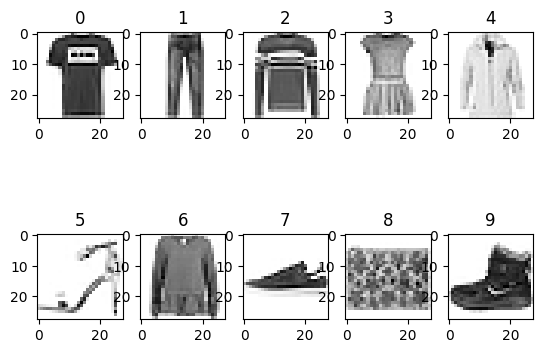

In [10]:
fig, axs = plt.subplots(2,5)

for i, idx in enumerate(indeces):
    axs[np.unravel_index(i, shape=(2,5))].imshow(X_train[idx, 0], cmap='Greys')
    axs[np.unravel_index(i, shape=(2,5))].title.set_text(i)

### training

In [13]:
layers = [
    Conv(num_filters=7, size=5, stride=1, activation='relu'),
    Conv(num_filters=5, size=3, stride=1, activation='relu'), 
    MaxPool(size=2, stride=2, activation='relu'),
    Dense(n_inputs=605, n_neurons=128, activation='relu'),
    Dense(n_inputs=128, n_neurons=10, activation='softmax'),
]

CNN_model = CNN(layers)

CNN_model.EarlyStop(monitor = "val_accuracy", min_delta = 1e-3, min_monitor=0.6, patience = 3, restore_best_layers=True)

CNN_model.train(X_train, y_train, X_val, y_val, epochs=1, learning_rate=0.01, lr_decay=0.005, step=10, val_step=500)

Epoch 1
[Image   510]: Avg Loss  1.71 | Avg Acc:  26.93% | Val Loss:  1.16 | Val Acc:  45.49%
[Image   520]: Avg Loss  0.69 | Avg Acc:  62.01% | Val Loss:  1.01 | Val Acc:  50.76%
[Image   530]: Avg Loss  1.21 | Avg Acc:  39.92% | Val Loss:  1.06 | Val Acc:  47.61%
[Image   540]: Avg Loss  1.08 | Avg Acc:  50.55% | Val Loss:  0.99 | Val Acc:  47.07%
[Image   550]: Avg Loss  1.26 | Avg Acc:  37.32% | Val Loss:  1.04 | Val Acc:  47.65%
[Image   560]: Avg Loss  1.39 | Avg Acc:  36.69% | Val Loss:  0.94 | Val Acc:  48.15%
[Image   570]: Avg Loss  0.85 | Avg Acc:  51.63% | Val Loss:  0.92 | Val Acc:  48.85%
[Image   580]: Avg Loss  2.24 | Avg Acc:  19.33% | Val Loss:  0.99 | Val Acc:  44.32%
[Image   590]: Avg Loss  0.94 | Avg Acc:  48.40% | Val Loss:  1.02 | Val Acc:  46.00%
[Image   600]: Avg Loss  1.25 | Avg Acc:  39.25% | Val Loss:  1.02 | Val Acc:  46.42%
[Image   610]: Avg Loss  1.28 | Avg Acc:  39.79% | Val Loss:  0.96 | Val Acc:  49.90%
[Image   620]: Avg Loss  1.04 | Avg Acc:  52.6

KeyboardInterrupt: 

In [14]:
CNN_model.restore_best_layers()

In [15]:
data = [go.Scatter(y = CNN_model.history['accuracy'][0], name = 'accuracy'),
        go.Scatter(y = CNN_model.history['val_accuracy'][0], name = 'val_accuracy')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'accuracy per epoch',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'epoch',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'accuracy',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':40}
)
go.Figure(data, layout)

In [16]:
data = [go.Scatter(y = CNN_model.history['loss'][0], name = 'loss'),
        go.Scatter(y = CNN_model.history['val_loss'][0], name = 'val_loss')]

layout = go.Layout(
    height = 1000,
    title = dict(
        text = 'loss per epoch',
        font_size = 30,
        x = .5
    ),
    xaxis_title = dict(
        text = 'epoch',
        font_size = 20
    ),
    yaxis_title = dict(
        text = 'loss',
        font_size = 20
    ),
    legend = dict(
        x = 0.02, y = .98,
        bgcolor = 'rgba(0,0,0,0)',
        font_size = 20
    ),
    margin={'r':0}
)
go.Figure(data, layout)

In [17]:
predictions = CNN_model.predict(X_test[:100])
accuracy_score(np.argmax(y_test[:100], 1), predictions)

0.66